In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

In [2]:
users_data = pd.read_excel('POHR_Bridge_Frequent_Users_Jul2021_Jun2022.xlsx')

In [3]:
individual_pre = users_data[users_data.Acct_Type.str.lower() == "individual pre-paid"].dropna().copy()

# Average number of trips taken each month over the two year period
individual_pre['monthly_avg_trips'] = individual_pre.Total_POHR / 24

# Monthly bills
individual_pre['monthly_cost'] = individual_pre.monthly_avg_trips * 1.75

# Sort monthly bills and cumulatively sum them to get the portion of the total for each one
individual_pre = individual_pre.sort_values('monthly_cost')
individual_pre['cumulative_cost'] = individual_pre.monthly_cost.cumsum()



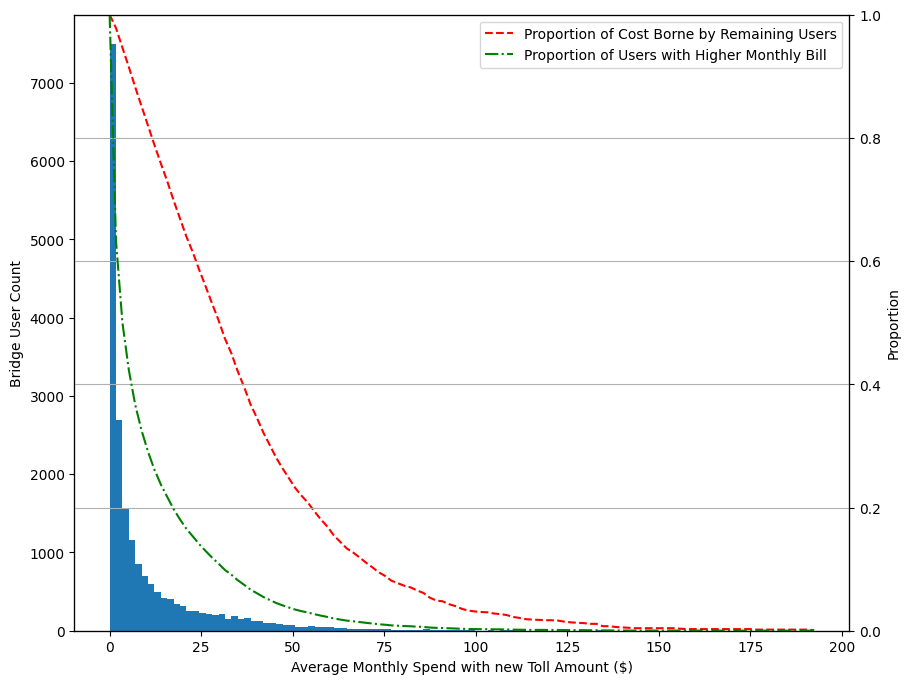

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))
histogram = ax.hist(individual_pre.monthly_cost, bins=list(np.arange(0, max(individual_pre.monthly_cost), 1.75)))
ax.set_ylabel('Bridge User Count')
ax.set_xlabel('Average Monthly Spend with new Toll Amount ($)')


cum_by_edge = [0]
proportion_users_remaining = [1.0]
for edge in histogram[1][1:]:
    counts_included = individual_pre.cumulative_cost[individual_pre.monthly_cost < edge]
    cum_by_edge.append(counts_included.iloc[-1])
    proportion_users_remaining.append((1 - len(counts_included)/individual_pre.shape[0]))

total_income = individual_pre.cumulative_cost.max()
cumulative_proportion = [v/total_income for v in cum_by_edge]

ax2 = ax.twinx()
proportion_cost_line, = ax2.plot(histogram[1], [1 - p for p in cumulative_proportion], '--r')
proportion_cost_line.set_label('Proportion of Cost Borne by Remaining Users')
ax2.set_ylim([0, 1])
ax2.yaxis.set_ticks([])
ax3 = ax2.twinx()
ax3.set_ylim([0, 1])
proportion_users_line, = ax3.plot(histogram[1], proportion_users_remaining, '-.g')
proportion_users_line.set_label('Proportion of Users with Higher Monthly Bill')
ax3.set_ylabel(ylabel='Proportion')
ax3.grid()

plt.legend(handles=[proportion_cost_line, proportion_users_line])